In [60]:
import pandas as pd 
import matplotlib.pyplot as plt 

import numpy as np 

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from keras.layers import InputLayer, LSTM, Dense, Flatten
from keras.models import Sequential
import keras

import tensorflow as tf 
import seaborn as sns


# Get Data from File

In [61]:
dataFileName = "CombinedData.csv"
df = pd.read_csv(dataFileName)
data = df[["datetime", "temp", "humidity", "precip"]]

# Data Analysis

Analysis of Temperature, Precipitation and Humidity over the past few years

In [62]:
# Temperature Data Analysis
t_data = data[["datetime", "temp"]].copy()
t_data.rename(columns={"datetime" : "Date", "temp" : "Temp"}, inplace = True)
t_data["Month"] = pd.DatetimeIndex(t_data["Date"]).month 
t_data["Year"] = pd.DatetimeIndex(t_data["Date"]).year

In [63]:
t_data["Year"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023], dtype=int64)

In [64]:
# Mean (Per Year)
yearly_mean = t_data.groupby(by="Year").mean(numeric_only = True)
yearly_mean.drop(columns=["Month"], inplace = True, axis = 1)

# Mean of Yearly Mean
total_yearly_mean = yearly_mean["Temp"].mean()
print("Total Yearly Mean:", total_yearly_mean)

# Adjust Current Yearly Mean to Overall Mean
yearly_mean["TotalMeanDiff"] = total_yearly_mean - yearly_mean["Temp"]

# Preview Yearly Mean
yearly_mean

Total Yearly Mean: 27.92804644808743


,Temp,TotalMeanDiff
Year,,
2000,27.621858,0.306189
2001,27.863836,0.064211
2002,27.536164,0.391882
2003,27.560822,0.367225
2004,27.563388,0.364658
2005,27.667671,0.260375
2006,27.782466,0.145581
2007,27.908767,0.019279
2008,27.552186,0.375861


In [65]:
# Augment T Data to Match the Total Mean Diff
t_augment_data = t_data.copy()
t_augment_data["YearAugment"] = t_augment_data["Temp"]
yearly_mean_dict = yearly_mean["TotalMeanDiff"].to_dict()

for year in yearly_mean.index:
    t_augment_data.loc[t_augment_data["Year"] == year, "YearAugment"] += yearly_mean_dict[year]    

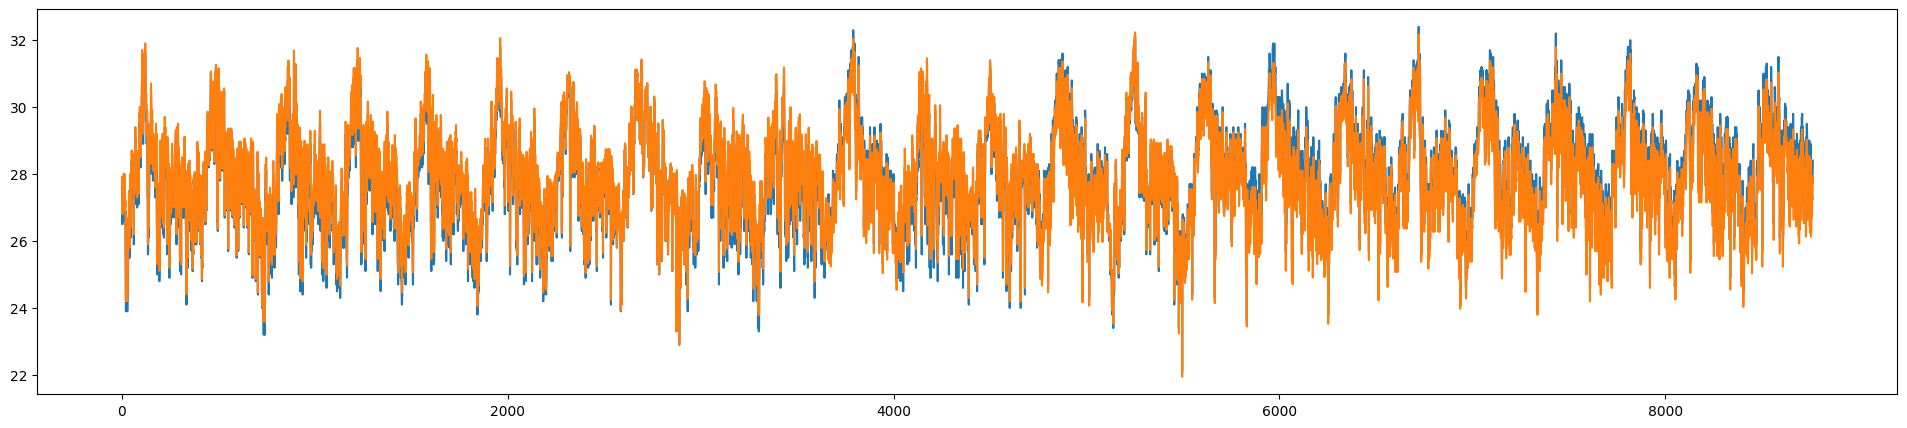

In [66]:
plt.figure(figsize=(24, 5))
plt.plot(t_augment_data["Temp"])
plt.plot(t_augment_data["YearAugment"])
plt.show()

In [67]:
# Check if it was indeed changed, all means for each year should not be equal to total yearly mean
# Effectively Removing Seasonality (Year Wise)
t_augment_data.groupby(by="Year").mean(numeric_only=True)["YearAugment"].unique(), total_yearly_mean

(array([27.92804645, 27.92804645]), 27.92804644808743)

In [68]:
# Monthly Data Time (Set it to be unique for each month and year)
t_augment_data["MonthYearCombination"] = t_augment_data["Year"] * 10000 + t_augment_data["Month"]

In [69]:
# Get Mean of Month and Year (Unique per Month and Year)
# Use Year Augment as this would be the second step for removing seasonality
month_year_mean = t_augment_data.groupby(by = "MonthYearCombination").mean(numeric_only = True)
total_month_year_mean = month_year_mean["YearAugment"].mean()
month_year_mean["TotalMeanDiff"] = total_month_year_mean - month_year_mean["YearAugment"]

In [70]:
month_year_mean.head()

,Temp,Month,Year,YearAugment,TotalMeanDiff
MonthYearCombination,,,,,
20000001,26.300000,1.0,2000.0,26.606189,1.319266
20000002,26.817241,2.0,2000.0,27.123430,0.802024
20000003,27.825806,3.0,2000.0,28.131995,-0.206541
20000004,29.976667,4.0,2000.0,30.282855,-2.357401
20000005,28.580645,5.0,2000.0,28.886834,-0.961379


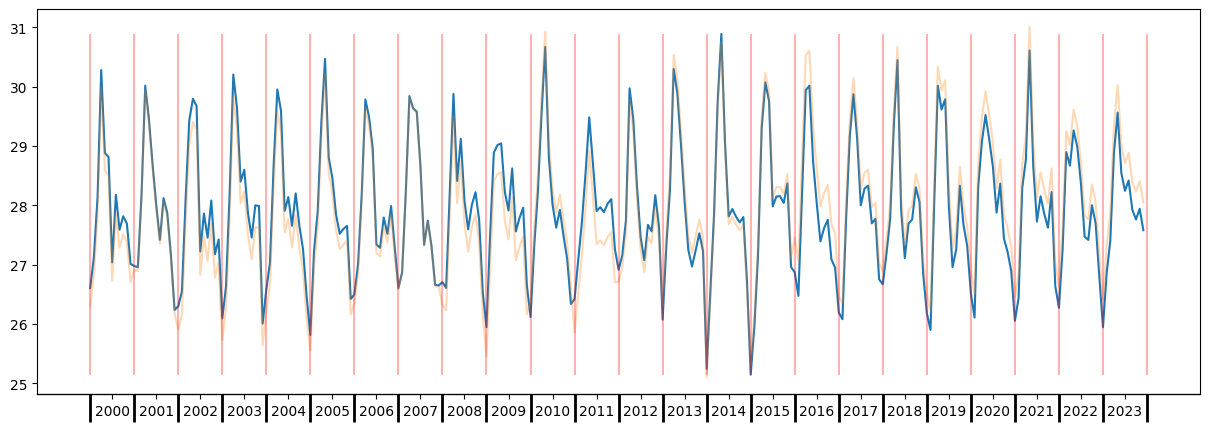

In [71]:
fig, ax = plt.subplots(figsize=(15, 5))

max_y = month_year_mean["YearAugment"].max()
min_y = month_year_mean["YearAugment"].min()


x_locations = np.arange(0, len(t_data["Year"].unique()) * 12 + 1, 12)
year_titles = np.arange(2000, len(t_data["Year"].unique()) + 2000)

year_title_locations = np.arange(6, len(t_data["Year"].unique()) * 12 + 1, 12)

year_title_axis = ax.secondary_xaxis(location = 0)
year_title_axis.set_xticks(year_title_locations, labels=year_titles)

year_bounds = ax.secondary_xaxis(location = 0)
year_bounds.set_xticks(x_locations, labels=[])
year_bounds.tick_params('x', width=2, length=20)


ax.plot(np.arange(0, len(month_year_mean)), month_year_mean["YearAugment"].tolist())
ax.plot(np.arange(0, len(month_year_mean)), month_year_mean["Temp"].tolist(), alpha = 0.3)
ax.set_xticks([])
ax.vlines(x_locations, min_y, max_y, colors=["red"], alpha = 0.3)
plt.show()

In [72]:
total_month_year_mean, total_yearly_mean

(27.925454336203952, 27.92804644808743)

In [73]:
final_t_augment_data = t_augment_data.copy()
final_t_augment_data["MonthYearAugment"] = final_t_augment_data["YearAugment"]
month_year_mean_dict = month_year_mean["TotalMeanDiff"].to_dict()

for month_year in tqdm(month_year_mean.index):
    final_t_augment_data.loc[final_t_augment_data["MonthYearCombination"] == month_year, "MonthYearAugment"] += month_year_mean_dict[month_year]


# # Augment T Data to Match the Total Mean Diff
# t_augment_data = t_data.copy()
# t_augment_data["YearAugment"] = t_augment_data["Temp"]
# yearly_mean_dict = yearly_mean["TotalMeanDiff"].to_dict()

# for year in yearly_mean.index:
#     t_augment_data.loc[t_augment_data["Year"] == year, "YearAugment"] += yearly_mean_dict[year]    

100%|██████████| 288/288 [00:00<00:00, 1461.83it/s]


In [74]:
final_t_augment_data

,Date,Temp,Month,Year,YearAugment,MonthYearCombination,MonthYearAugment
0,2000-01-01,27.6,1,2000,27.906189,20000001,29.225454
1,2000-01-02,27.4,1,2000,27.706189,20000001,29.025454
2,2000-01-03,26.5,1,2000,26.806189,20000001,28.125454
3,2000-01-04,26.5,1,2000,26.806189,20000001,28.125454
4,2000-01-05,26.8,1,2000,27.106189,20000001,28.425454
...,...,...,...,...,...,...,...
8761,2023-12-27,27.4,12,2023,26.932156,20230012,27.277067
8762,2023-12-28,27.8,12,2023,27.332156,20230012,27.677067
8763,2023-12-29,27.7,12,2023,27.232156,20230012,27.577067
8764,2023-12-30,28.0,12,2023,27.532156,20230012,27.877067


In [75]:
# Get Mean of Month and Year (Unique per Month and Year)
# Use Year Augment as this would be the second step for removing seasonality
p_month_year_mean = final_t_augment_data.groupby(by = "MonthYearCombination").mean(numeric_only = True)


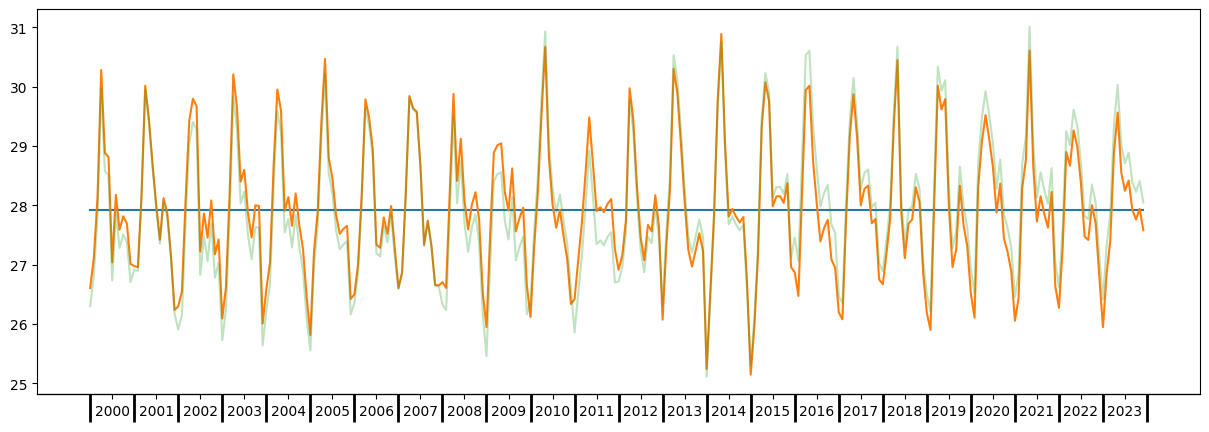

In [76]:
fig, ax = plt.subplots(figsize=(15, 5))

max_y = p_month_year_mean["MonthYearAugment"].max()
min_y = p_month_year_mean["MonthYearAugment"].min()


x_locations = np.arange(0, len(t_data["Year"].unique()) * 12 + 1, 12)
year_titles = np.arange(2000, len(t_data["Year"].unique()) + 2000)

year_title_locations = np.arange(6, len(t_data["Year"].unique()) * 12 + 1, 12)

year_title_axis = ax.secondary_xaxis(location = 0)
year_title_axis.set_xticks(year_title_locations, labels=year_titles)

year_bounds = ax.secondary_xaxis(location = 0)
year_bounds.set_xticks(x_locations, labels=[])
year_bounds.tick_params('x', width=2, length=20)


ax.plot(np.arange(0, len(p_month_year_mean)), p_month_year_mean["MonthYearAugment"].tolist())
ax.plot(np.arange(0, len(p_month_year_mean)), p_month_year_mean["YearAugment"].tolist())
ax.plot(np.arange(0, len(p_month_year_mean)), p_month_year_mean["Temp"].tolist(), alpha = 0.3)
ax.set_xticks([])
ax.vlines(x_locations, min_y, max_y, colors=["red"], alpha = 0.3)
plt.show()

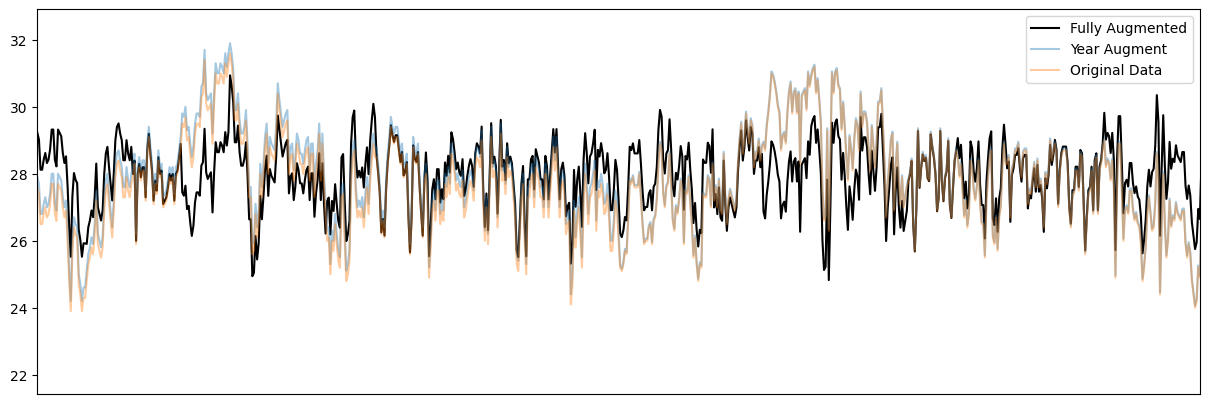

In [77]:
# Plot the Changes starting from Original, Year - Augmented, Month & Year - Augmented
fig, ax = plt.subplots(figsize=(15, 5))

max_y = final_t_augment_data["MonthYearAugment"].max()
min_y = final_t_augment_data["MonthYearAugment"].min()

ax.plot(final_t_augment_data["MonthYearAugment"].tolist(), alpha = 1, label = "Fully Augmented", color = "black")
ax.plot(final_t_augment_data["YearAugment"].tolist(), alpha = 0.4, label = "Year Augment")
ax.plot(final_t_augment_data["Temp"].tolist(), alpha = 0.4, label = "Original Data")
plt.legend()
ax.set_xlim(0, 365 * 2)
ax.set_xticks([])
# ax.vlines(x_locations, min_y, max_y, colors=["red"], alpha = 0.3)
plt.show()

In [78]:
ymT, mymT, ftT = yearly_mean["Temp"], month_year_mean.groupby(by="Year").mean(numeric_only=True)["YearAugment"], final_t_augment_data.groupby(by="Year").mean(numeric_only = True)["MonthYearAugment"]

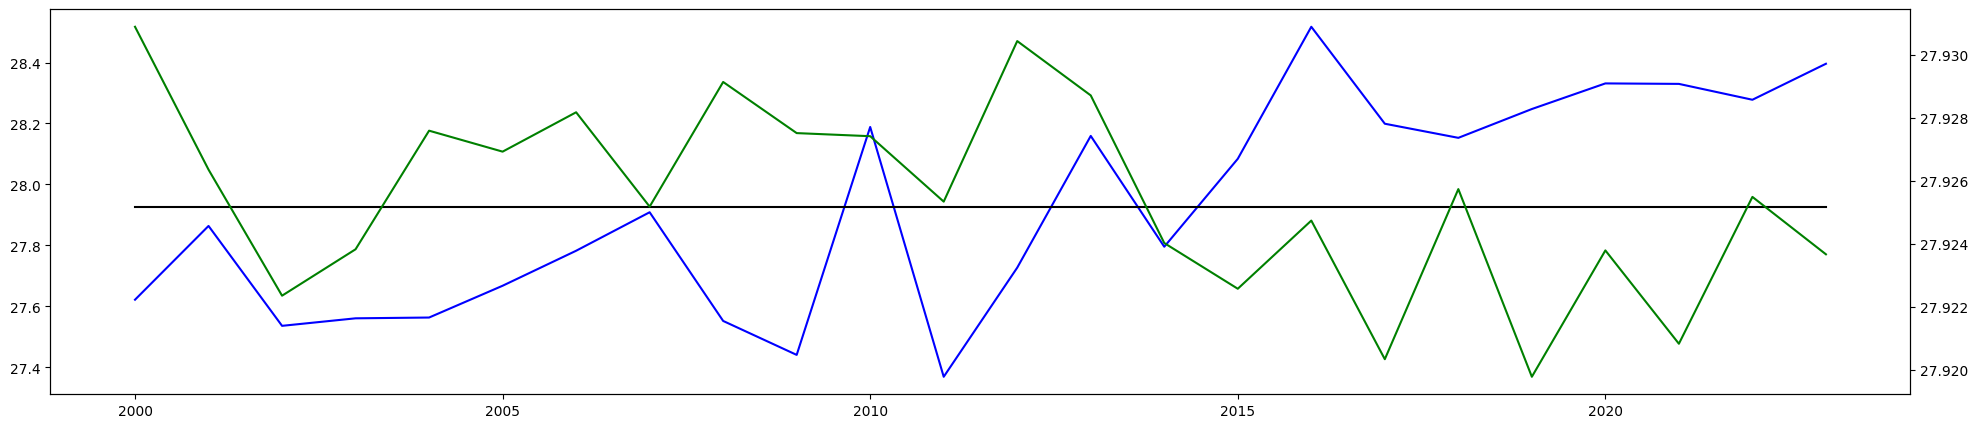

In [79]:
fig, ax1 = plt.subplots(figsize = (24, 5))
ax1.plot(ymT, label = "Yearly", color = "blue")
ax1.plot(ftT, label = "Final Augmented", color = "black")

ax2 = ax1.twinx()
ax2.plot(mymT, label = "Monthly - Yearly", color = "green")
plt.show()

In [80]:
yearly_mean.head()

,Temp,TotalMeanDiff
Year,,
2000,27.621858,0.306189
2001,27.863836,0.064211
2002,27.536164,0.391882
2003,27.560822,0.367225
2004,27.563388,0.364658


In [81]:
month_year_mean.head()

,Temp,Month,Year,YearAugment,TotalMeanDiff
MonthYearCombination,,,,,
20000001,26.300000,1.0,2000.0,26.606189,1.319266
20000002,26.817241,2.0,2000.0,27.123430,0.802024
20000003,27.825806,3.0,2000.0,28.131995,-0.206541
20000004,29.976667,4.0,2000.0,30.282855,-2.357401
20000005,28.580645,5.0,2000.0,28.886834,-0.961379


In [82]:
yearly_mean

,Temp,TotalMeanDiff
Year,,
2000,27.621858,0.306189
2001,27.863836,0.064211
2002,27.536164,0.391882
2003,27.560822,0.367225
2004,27.563388,0.364658
2005,27.667671,0.260375
2006,27.782466,0.145581
2007,27.908767,0.019279
2008,27.552186,0.375861


In [83]:
# Yearly Mean - YM
# Monthly and Yearly Mean - MYLM
# Data Preparation for Mean Prediction

train_size = 0.7
test_size = 0.3

WINDOW_SIZE = 2
YM_Copy = yearly_mean["TotalMeanDiff"].to_list()
YM_Copy_X = []
YM_Copy_Y = []
for i in range(WINDOW_SIZE, len(yearly_mean) - WINDOW_SIZE):
    YM_Copy_X.append(YM_Copy[i : i + WINDOW_SIZE])
    YM_Copy_Y.append(YM_Copy[i + WINDOW_SIZE])

MYLM_Copy = month_year_mean["TotalMeanDiff"].to_list()
MYLM_Copy_X = []
MYLM_Copy_Y = []
for i in range(WINDOW_SIZE, len(month_year_mean) - WINDOW_SIZE):
    MYLM_Copy_X.append(MYLM_Copy[i : i + WINDOW_SIZE])
    MYLM_Copy_Y.append(MYLM_Copy[i + WINDOW_SIZE])

YM_TRAIN_X = YM_Copy_X[:int(train_size * len(YM_Copy_X))]
YM_TEST_X = YM_Copy_X[int(train_size * len(YM_Copy_X)):]

YM_TRAIN_Y = YM_Copy_Y[:int(train_size * len(YM_Copy_Y))]
YM_TEST_Y = YM_Copy_Y[int(train_size * len(YM_Copy_Y)):]

MYLM_TRAIN_X = MYLM_Copy_X[:int(train_size * len(MYLM_Copy_X))]
MYLM_TEST_X = MYLM_Copy_X[int(train_size * len(MYLM_Copy_X)):]

MYLM_TRAIN_Y = MYLM_Copy_Y[:int(train_size * len(MYLM_Copy_Y))]
MYLM_TEST_Y = MYLM_Copy_Y[int(train_size * len(MYLM_Copy_Y)):]

In [84]:
# Yearly_Mean_Predictor = SVR(kernel = "rbf")
Yearly_Mean_Predictor = RandomForestRegressor()
Yearly_Mean_Predictor.fit(YM_TRAIN_X, YM_TRAIN_Y)

RandomForestRegressor()

In [85]:
Y_PRED = Yearly_Mean_Predictor.predict(YM_TEST_X)

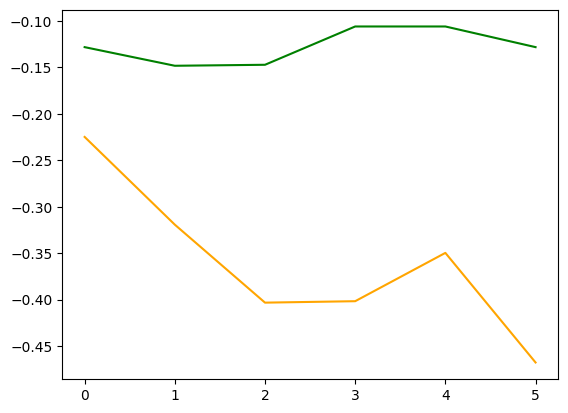

In [86]:
plt.figure()
plt.plot(Y_PRED, label = "Predictions", color = "green")
plt.plot(YM_TEST_Y, label = "Real", color = "orange")
plt.show()

In [87]:
SlidingWindow = YM_TRAIN_X[-1]

R_Y_PRED = []

for x in range(len(YM_TEST_Y)):
    current_prediction = Yearly_Mean_Predictor.predict(np.array([SlidingWindow]))
    R_Y_PRED.append(current_prediction[0])

    SlidingWindow = np.roll(SlidingWindow, -1)
    SlidingWindow[-1] = current_prediction[0]


In [88]:
R_Y_PRED

[-0.18821167003518613,
 -0.19276044614118185,
 -0.22914297477356438,
 -0.19718916835092795,
 -0.1889655662849052,
 -0.21533475559548232]

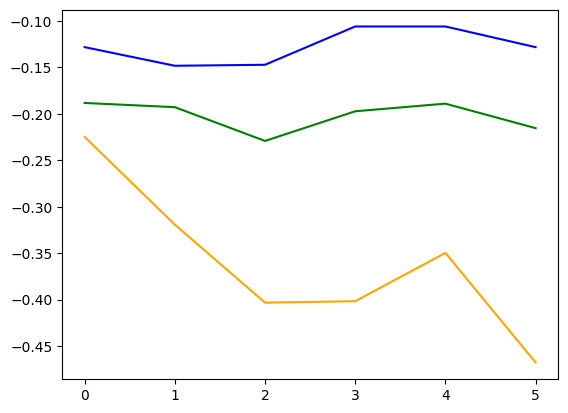

In [89]:
plt.figure()
plt.plot(Y_PRED, label = "Predictions", color = "blue")
plt.plot(R_Y_PRED, label = "R Predictions", color = "green")
plt.plot(YM_TEST_Y, label = "Real", color = "orange")
plt.show()

In [90]:
Month_Year_Mean_Predictor = SVR(kernel = "rbf")
Month_Year_Mean_Predictor.fit(MYLM_TRAIN_X, MYLM_TRAIN_Y)

SVR()

In [91]:
Y_PRED = Month_Year_Mean_Predictor.predict(MYLM_TEST_X)

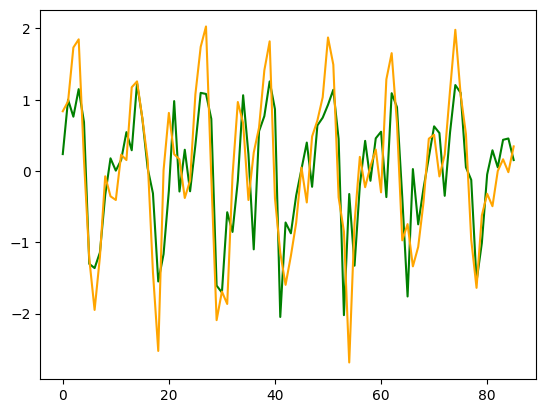

In [92]:
plt.figure()
plt.plot(Y_PRED, label = "Predictions", color = "green")
plt.plot(MYLM_TEST_Y, label = "Real", color = "orange")
plt.show()

In [93]:
final_t_augment_data.columns

Index(['Date', 'Temp', 'Month', 'Year', 'YearAugment', 'MonthYearCombination',
       'MonthYearAugment'],
      dtype='object')

In [94]:
Final_STD = np.std(final_t_augment_data["MonthYearAugment"])
Final_STD

0.9446261885796207

In [95]:
SlidingWindow = MYLM_TRAIN_X[-1]

R_Y_PRED = []

for x in tqdm(range(len(MYLM_TRAIN_Y))):
    current_prediction = Yearly_Mean_Predictor.predict(np.array([SlidingWindow]))
    # current_prediction += np.random.normal(loc = 0, scale = Final_STD)
    R_Y_PRED.append(current_prediction[0])

    SlidingWindow = np.roll(SlidingWindow, -1)
    SlidingWindow[-1] = current_prediction[0]

100%|██████████| 198/198 [00:01<00:00, 119.05it/s]


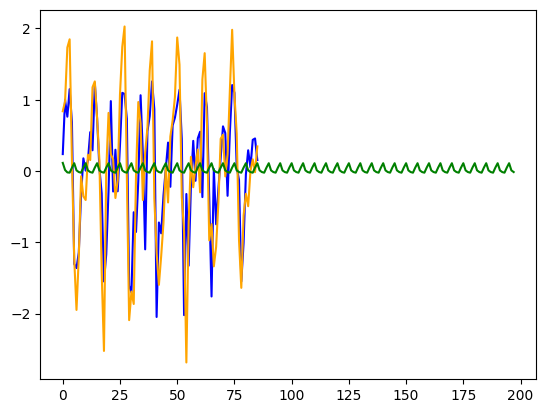

In [96]:
plt.figure()
plt.plot(Y_PRED, label = "Predictions", color = "blue")
plt.plot(MYLM_TEST_Y, label = "Real", color = "orange")
plt.plot(R_Y_PRED, label = "R Predictions", color = "green")
# plt.xlim(0, len(MYLM_TEST_Y))
plt.show()

# Tensorflow Method

Using Custom Loss Functions

In [97]:
WINDOW_SIZE

2

In [98]:
import numpy as np

# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
history = model.fit(x, y, epochs=3)

Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 0.2639
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 0.2484
Epoch 3/3
32/32 [==============================] - 0s 968us/step - loss: 0.2340


In [99]:
class Custom_Loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):        
        # log_y_pred = tf.math.log(y_pred)
        # elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        # return tf.reduce_mean(tf.reduce_sum(elements,axis=1))
        return 100
    

In [100]:
y_true = tf.constant([100, 200, 300])
y_pred = tf.constant([10, 10, 20])


In [101]:
print(tf.keras.losses.MAE(y_true, y_pred).numpy())
print('My Custom Loss : ', Custom_Loss ()(y_true, y_pred).numpy())

186
My Custom Loss :  100


In [102]:
class AutoRegressiveLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):        
        
        # log_y_pred = tf.math.log(y_pred)
        # elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        # return tf.reduce_mean(tf.reduce_sum(elements,axis=1))
        return 100
    
    

In [103]:
Month_Year_Mean_Predictor_TF = Sequential([
    InputLayer(input_shape = (WINDOW_SIZE, 1)),
    LSTM(64, return_sequences = True),
    LSTM(64),
    Flatten(),
    Dense(1)
])

Month_Year_Mean_Predictor_TF.compile(loss="mse", optimizer = "rmsprop", metrics = ["mae"])

In [104]:
history = Month_Year_Mean_Predictor_TF.fit(x = MYLM_TRAIN_X, y = MYLM_TRAIN_Y, epochs = 2)

Epoch 1/2
7/7 [==============================] - 4s 3ms/step - loss: 1.1705 - mae: 0.8326
Epoch 2/2
7/7 [==============================] - 0s 4ms/step - loss: 1.1155 - mae: 0.8113
